<a href="https://colab.research.google.com/github/ShashankBhat-18/Wildlife-roadkill-prevention/blob/main/WildlifeMigrationPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection from GBIF
 **Data Collection and Cleaning:** Wildlife sighting data is uploaded (from GBIF), cleaned by removing duplicates and handling missing values, and then saved.  Date/time information is extracted from the 'eventDate' column into separate year, month, day, hour, minute, and second columns.  Latitude and longitude values are validated to be within their expected ranges.

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

df = df.drop_duplicates()
df = df.dropna(subset=['decimalLatitude', 'decimalLongitude', 'eventDate'])

df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce')
df = df.dropna(subset=['eventDate'])

df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second

df = df[(df['decimalLatitude'].between(-90, 90)) & (df['decimalLongitude'].between(-180, 180))]

cleaned_file = 'gbif_data_cleaned.csv'
df.to_csv(cleaned_file, index=False)

print(f"Cleaned data saved to '{cleaned_file}' with {len(df)} records.")

Saving gbif_data.csv to gbif_data.csv
Cleaned data saved to 'gbif_data_cleaned.csv' with 21054 records.


# Exploratory data analysis of the cleaned Gbif data
**Exploratory Data Analysis (EDA):**  The cleaned data is then explored to understand its characteristics. This involves:
* Identifying the most frequently observed species.
* Visualizing the geographic distribution of sightings using scatterplots.
* Analyzing sightings over time (by hour, month, and creating a heatmap of hourly sightings across months).
* Examining the relationship between species and time of day.
* Plotting the monthly sighting trends.
* Visualizing the geographic hotspots of sightings using kernel density estimation.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
file_path = 'gbif_data_cleaned.csv'
df = pd.read_csv(file_path)

# 1. Most Common Species
top_species = df['scientificName'].value_counts().head(10)
print("\nTop 10 Most Observed Species:")
print(top_species)


Top 10 Most Observed Species:
scientificName
Axis axis (Erxleben, 1777)                         1375
Macaca radiata (É.Geoffroy Saint-Hilaire, 1812)     996
Funambulus pennantii Wroughton, 1905                951
Macaca mulatta (Zimmermann, 1780)                   894
Panthera tigris tigris                              887
Boselaphus tragocamelus (Pallas, 1766)              758
Semnopithecus entellus (Dufresne, 1797)             728
Elephas maximus indicus Cuvier, 1798                693
Ratufa indica (Erxleben, 1777)                      683
Pteropus giganteus (Brünnich, 1782)                 661
Name: count, dtype: int64


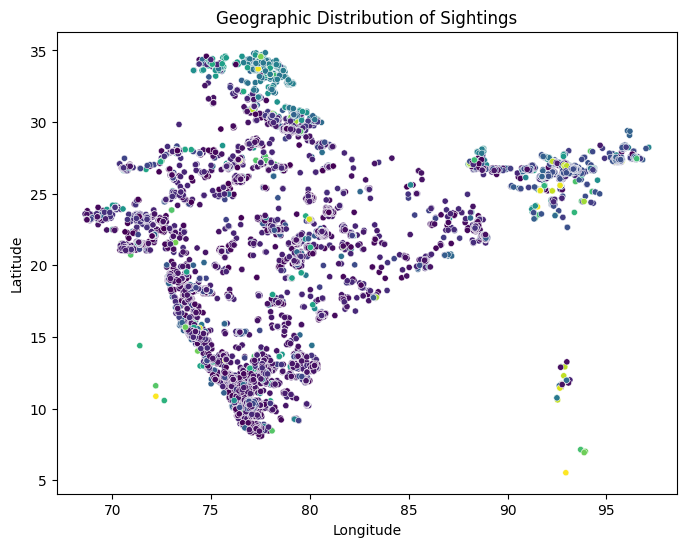

In [ ]:
# 2. Geographic Distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='decimalLongitude', y='decimalLatitude',
                hue='scientificName', palette='viridis', legend=False, s=20)
plt.title('Geographic Distribution of Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

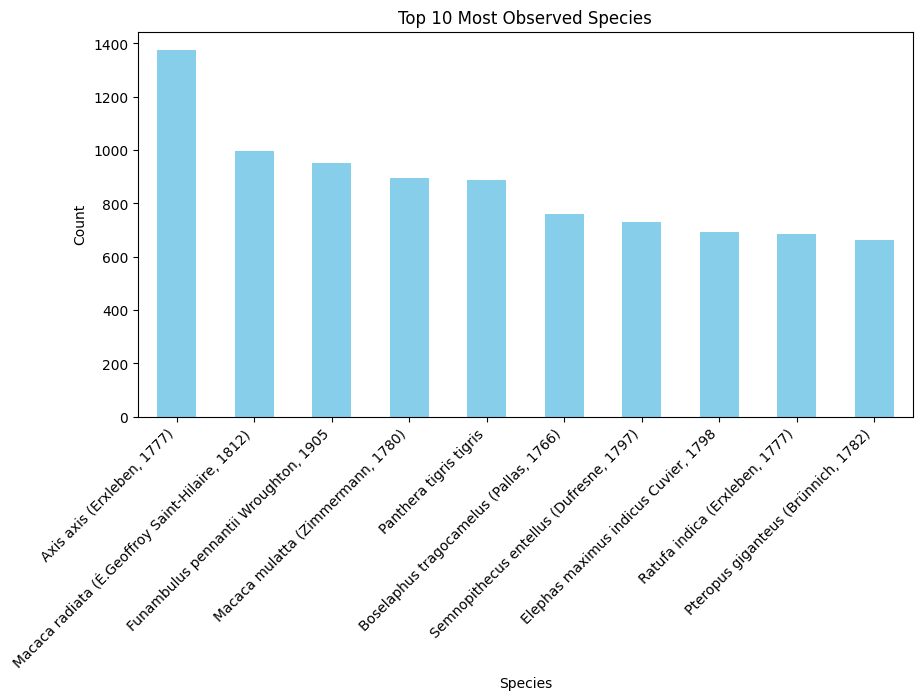

In [ ]:
# Plot top species
plt.figure(figsize=(10, 5))
top_species.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Observed Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

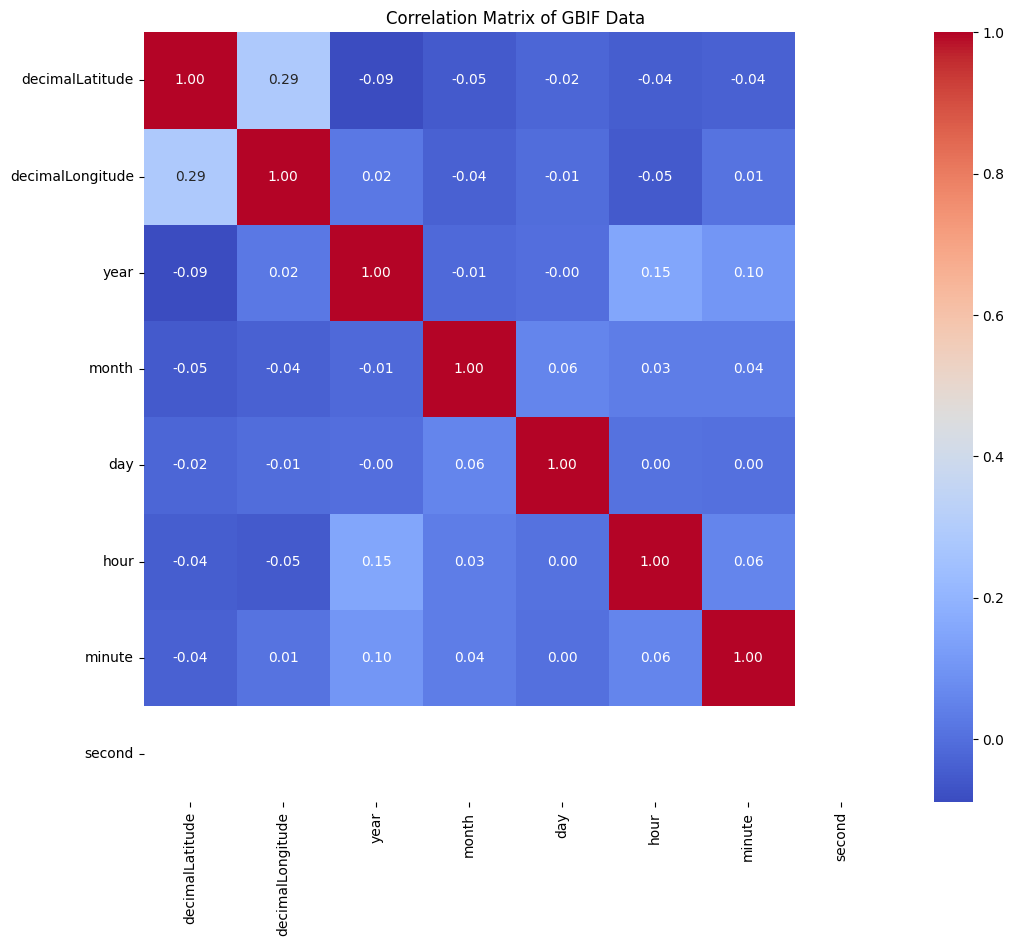

In [ ]:


# Calculate the correlation matrix, selecting only numeric columns
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of GBIF Data')
plt.show()

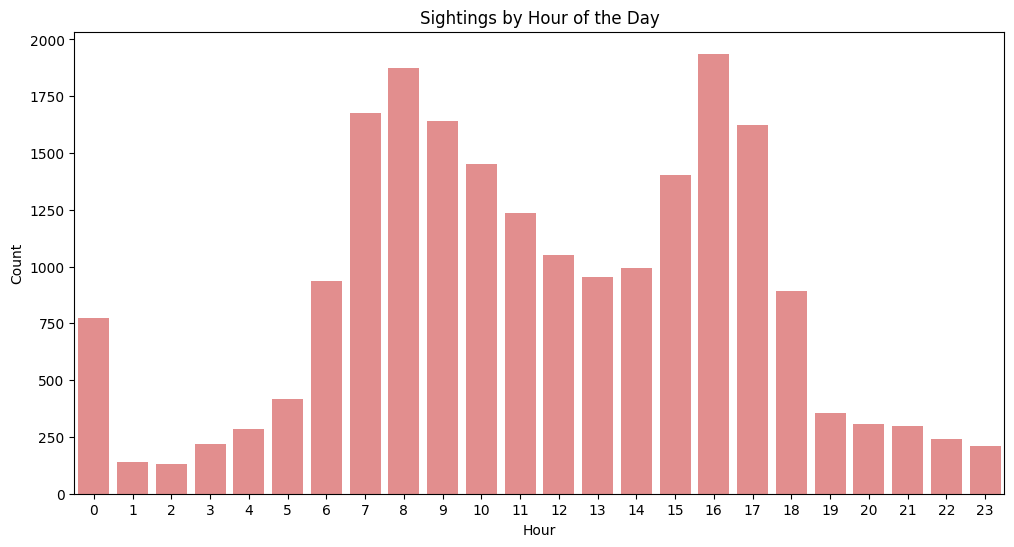

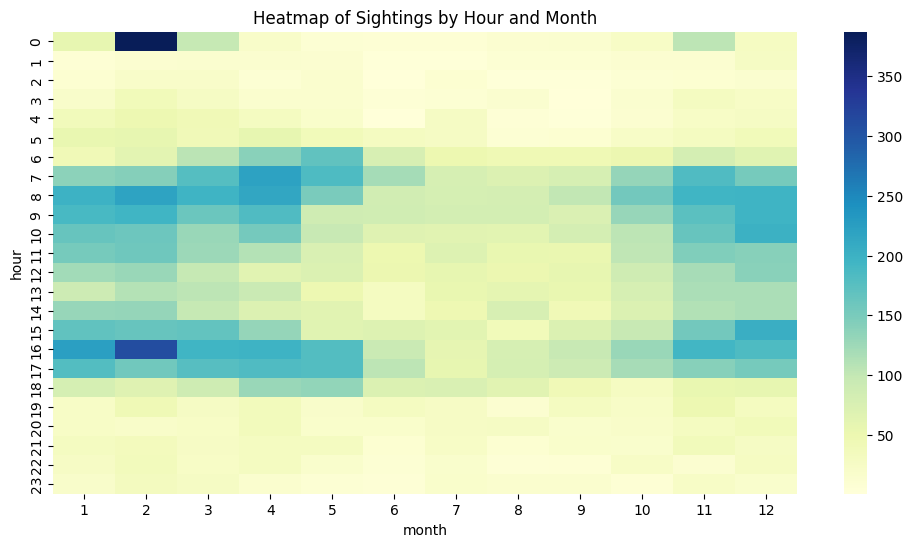

In [ ]:
# 3. Time-Based Analysis
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', color='lightcoral')
plt.title('Sightings by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot_table(index='hour', columns='month',
            values='scientificName', aggfunc='count', fill_value=0), cmap='YlGnBu')
plt.title('Heatmap of Sightings by Hour and Month')
plt.show()

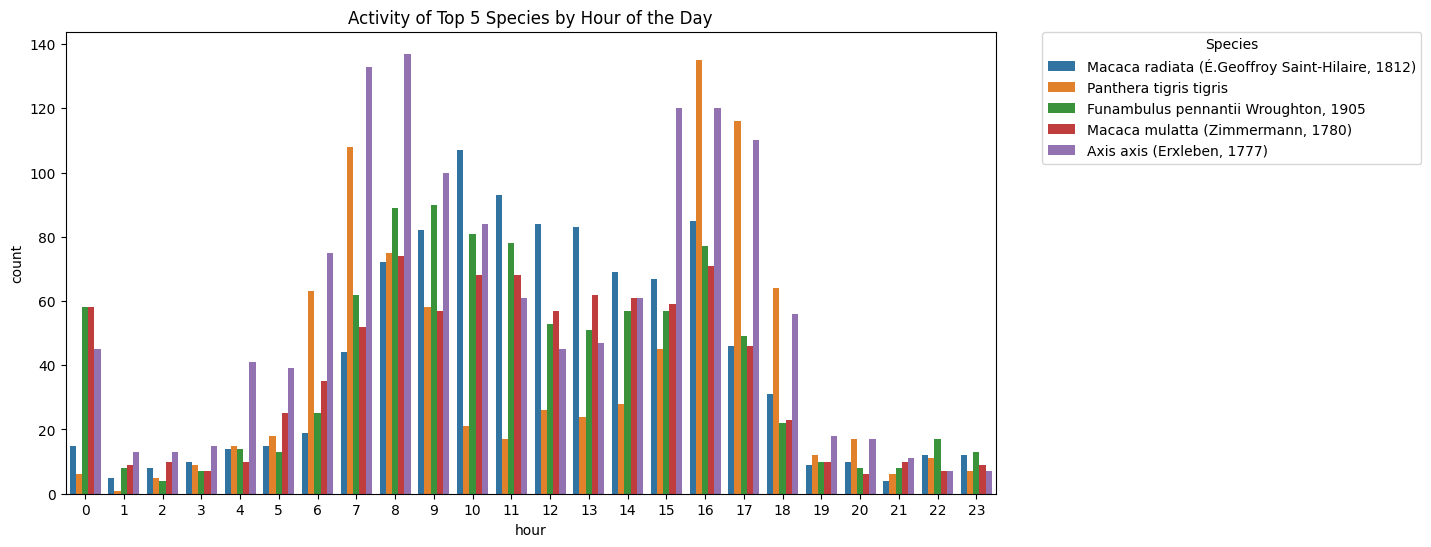

In [ ]:
# Top 5 most observed species
top_5_species = df['scientificName'].value_counts().head(5).index
filtered_df = df[df['scientificName'].isin(top_5_species)]

# Species vs. Time of Day (Limited to Top 5)
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='hour',
              hue='scientificName', palette='tab10')
plt.title('Activity of Top 5 Species by Hour of the Day')
plt.legend(title='Species', bbox_to_anchor=(
    1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

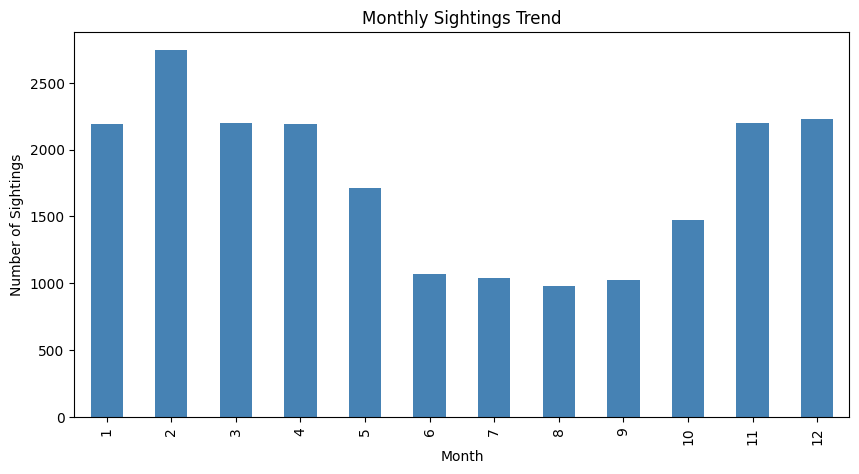

In [ ]:
monthly_trend = df.groupby('month')['scientificName'].count()
plt.figure(figsize=(10, 5))
monthly_trend.plot(kind='bar', color='steelblue')
plt.title('Monthly Sightings Trend')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.show()


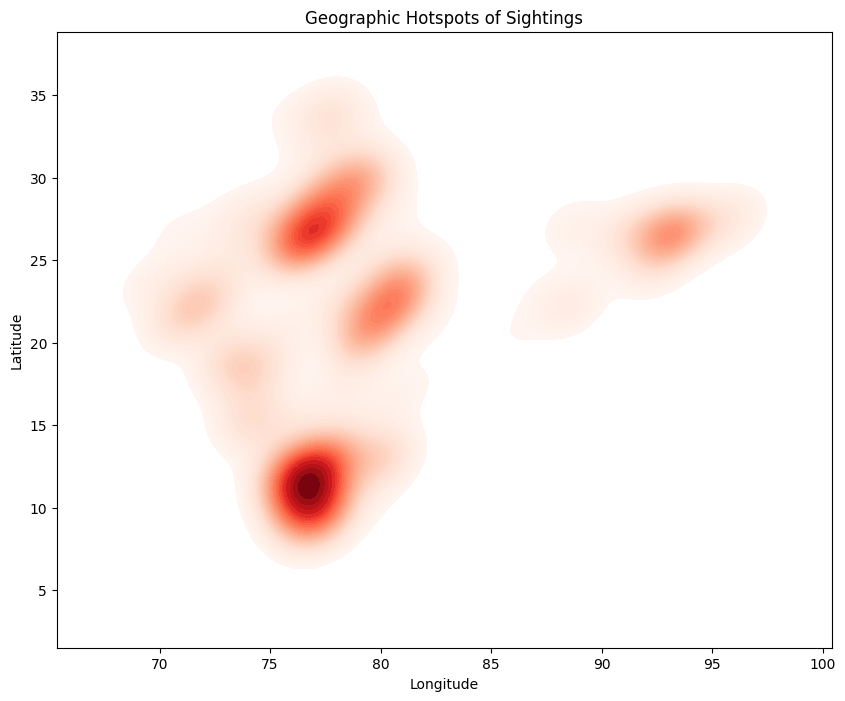

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df, x='decimalLongitude', y='decimalLatitude',
            fill=True, cmap='Reds', thresh=0.05, levels=50)
plt.title('Geographic Hotspots of Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Data Collection from Open street map for the road network

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import geopandas as gpd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the correct file path
file_path = '/content/drive/MyDrive/Wilidlife/hotosm_ind_roads_lines_shp.shp' # Update with the correct folder name

# Load the road network shapefile using geopandas
roads = gpd.read_file(file_path)

# Ensure the CRS is set to WGS84 (EPSG:4326)
roads = roads.to_crs(epsg=4326)

print("Road network shapefile loaded and CRS set to WGS84.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Road network shapefile loaded and CRS set to WGS84.


## Splitting the Dataset into batches (different zones of the country) for easier fetching
**Road Network Data Integration:** Road network data from OpenStreetMap (in shapefile format) is loaded and processed.  The code defines different zones of India (Northern, Central, Western, Eastern, and Southern). For each zone, it does the following:
* Filters both the wildlife sighting data and the road network data to include only data within the defined zone boundaries.
* Converts both datasets to a projected coordinate system (EPSG:3857) for accurate distance calculations.
* Performs a spatial join to find the nearest road segment to each wildlife sighting. The distance to the nearest road is stored in a new column.
* Converts the data back to the original latitude/longitude coordinate system (EPSG:4326).
* Saves the processed data for each zone into separate CSV files.
* Finally, combines all the zone data (excluding the initially processed Southern zone data) into a national-level dataset.

In [ ]:
# Southern Zone bounding box
south_zone = roads[
    (roads['geometry'].bounds.miny >= 8.0) &
    (roads['geometry'].bounds.maxy <= 15.0) &
    (roads['geometry'].bounds.minx >= 75.0) &
    (roads['geometry'].bounds.maxx <= 80.0)
]
#Filter Wildlife Data for Southern Zone
southern_zone = df[
    (df['decimalLatitude'] >= 8.0) &
    (df['decimalLatitude'] <= 15.0) &
    (df['decimalLongitude'] >= 75.0) &
    (df['decimalLongitude'] <= 80.0)
]


In [ ]:
# Ensure wildlife GeoDataFrame is already created
gdf_wildlife = gpd.GeoDataFrame(
    southern_zone,
    geometry=gpd.points_from_xy(
        southern_zone['decimalLongitude'], southern_zone['decimalLatitude']
    ),
    crs="EPSG:4326"
)

# Spatial join to find the nearest road to each wildlife sighting
nearest_road = gpd.sjoin_nearest(
    gdf_wildlife, south_zone, how="left", distance_col="distance_to_road"
)


/usr/local/lib/python3.11/dist-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
# Convert wildlife data to projected CRS
gdf_wildlife = gdf_wildlife.to_crs(epsg=3857)

# Convert road network to projected CRS
south_zone = south_zone.to_crs(epsg=3857)

In [ ]:
# Perform spatial join (find nearest road)
nearest_road = gpd.sjoin_nearest(
    gdf_wildlife, south_zone, how="left", distance_col="distance_to_road"
)
nearest_road = nearest_road.to_crs(epsg=4326)
output_file = 'southern_zone_wildlife_traffic.csv'
nearest_road.to_csv(output_file, index=False)
print(f"Data saved to '{output_file}' with {len(nearest_road)} records.")


Data saved to 'southern_zone_wildlife_traffic.csv' with 5846 records.


In [ ]:
nearest_road.head()

,scientificName,decimalLatitude,decimalLongitude,eventDate,country,basisOfRecord,year,month,day,hour,minute,second,geometry,index_right,distance_to_road
4,"Funambulus tristriatus (Waterhouse, 1837)",10.527642,76.214435,2025-01-01 15:47:00,India,HUMAN_OBSERVATION,2025,1,1,15,47,0,POINT (76.21443 10.52764),9727367,3.905995
5,"Felis catus Linnaeus, 1758",10.527642,76.214435,2025-01-01 15:51:00,India,HUMAN_OBSERVATION,2025,1,1,15,51,0,POINT (76.21443 10.52764),9727367,3.905995
7,"Pteropus giganteus (Brünnich, 1782)",10.527642,76.214435,2025-01-02 18:42:00,India,HUMAN_OBSERVATION,2025,1,2,18,42,0,POINT (76.21443 10.52764),9727367,3.905995
8,"Pteropus giganteus (Brünnich, 1782)",10.527642,76.214435,2025-01-02 17:56:00,India,HUMAN_OBSERVATION,2025,1,2,17,56,0,POINT (76.21443 10.52764),9727367,3.905995
9,"Canis aureus Linnaeus, 1758",13.162515,77.474040,2025-01-04 13:07:00,India,HUMAN_OBSERVATION,2025,1,4,13,7,0,POINT (77.47404 13.16252),5299512,113.353797


In [ ]:
print(nearest_road.columns)

Index(['scientificName', 'decimalLatitude', 'decimalLongitude', 'eventDate',
       'country', 'basisOfRecord', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'geometry', 'index_right', 'distance_to_road'],
      dtype='object')


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

#Load Wildlife Data
file_path = "gbif_data.csv"  # Update with actual path if different
df = pd.read_csv(file_path)

#Load Road Network Data (GeoJSON format)
roads = gpd.read_file('/content/drive/MyDrive/Wilidlife/hotosm_ind_roads_lines_shp.shp')

# Define Bounding Boxes for Remaining Zones
zones = {
    'Northern Zone': {'north': 37.0, 'south': 29.0, 'east': 80.0, 'west': 73.0},
    'Central Zone': {'north': 26.0, 'south': 20.0, 'east': 84.0, 'west': 75.0},
    'Western Zone': {'north': 27.0, 'south': 21.0, 'east': 75.0, 'west': 68.0},
    'Eastern Zone': {'north': 28.0, 'south': 20.0, 'east': 97.0, 'west': 85.0}
}

# Create an empty list to store results
combined_data = []

# Loop Through Remaining Zones
for zone_name, bbox in zones.items():
    print(f"Processing {zone_name}...")

    # Filter wildlife data for the current zone
    zone_wildlife = df[
        (df['decimalLatitude'] >= bbox['south']) & (df['decimalLatitude'] <= bbox['north']) &
        (df['decimalLongitude'] >= bbox['west']) & (df['decimalLongitude'] <= bbox['east'])
    ]

    if zone_wildlife.empty:
        print(f"No wildlife data for {zone_name}. Skipping...")
        continue

    # Convert wildlife data to GeoDataFrame
    gdf_wildlife = gpd.GeoDataFrame(
        zone_wildlife,
        geometry=gpd.points_from_xy(
            zone_wildlife['decimalLongitude'], zone_wildlife['decimalLatitude']
        ),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Filter road network for the current zone
    zone_roads = roads.cx[
        bbox['west']:bbox['east'], bbox['south']:bbox['north']
    ].to_crs(epsg=3857)

    if zone_roads.empty:
        print(f"No road data for {zone_name}. Skipping...")
        continue

    # Perform Nearest Spatial Join (Find Closest Road)
    nearest_road = gpd.sjoin_nearest(
        gdf_wildlife, zone_roads, how="left", distance_col="distance_to_road"
    )

    # Convert back to latitude/longitude (EPSG:4326)
    nearest_road = nearest_road.to_crs(epsg=4326)

    # Keep Relevant Fields
    desired_columns = ['scientificName', 'decimalLatitude', 'decimalLongitude', 'distance_to_road']
    available_columns = list(nearest_road.columns)

    for col in ['highway',]: # Add other potentially missing columns here
        if col in available_columns:
            desired_columns.append(col)

    nearest_road = nearest_road[desired_columns]

    # Save Individual Zone Output to CSV
    zone_file = f"{zone_name.replace(' ', '_').lower()}_wildlife_traffic.csv"
    nearest_road.to_csv(zone_file, index=False)
    print(f"{zone_name} data saved with {len(nearest_road)} records to '{zone_file}'.")

    # Append Result to Combined Data
    combined_data.append(nearest_road)

# Combine All Zone Data (Except Southern)
final_data = pd.concat(combined_data, ignore_index=True)

# Save Combined Data to CSV
output_file = 'national_wildlife_traffic.csv'
final_data.to_csv(output_file, index=False)
print(f"Combined data saved with {len(final_data)} records to '{output_file}'.")

Processing Northern Zone...
Northern Zone data saved with 6289 records to 'northern_zone_wildlife_traffic.csv'.
Processing Central Zone...
Central Zone data saved with 8240 records to 'central_zone_wildlife_traffic.csv'.
Processing Western Zone...
Western Zone data saved with 3344 records to 'western_zone_wildlife_traffic.csv'.
Processing Eastern Zone...
Eastern Zone data saved with 8192 records to 'eastern_zone_wildlife_traffic.csv'.
Combined data saved with 26065 records to 'national_wildlife_traffic.csv'.


# Data preprocessing
**Data Preprocessing:**
* Combines the cleaned wildlife sighting data and the road network data based on latitude and longitude, restoring the 'eventDate' column.
* Creates additional time-based features (year, month, day, hour, minute, second).
* Normalizes numerical features (latitude, longitude, distance to road).
* Encodes the categorical features ('scientificName' and different highway types) using label encoding and one-hot encoding, respectively.  The code fills NaNs in highway type columns with 0 to enable one-hot encoding.
* Handles NaN and infinite values by removing them or replacing with medians.

In [ ]:
import pandas as pd

# Load both datasets
df_gbif = pd.read_csv('gbif_data_cleaned.csv')  # Contains eventDate
df_wildlife = pd.read_csv('national_wildlife_traffic.csv')  # Missing eventDate

# Merge eventDate back using latitude & longitude
df_merged = df_wildlife.merge(df_gbif[['decimalLatitude', 'decimalLongitude', 'eventDate']],
                              on=['decimalLatitude', 'decimalLongitude'],
                              how='left')

# Save the new dataset
df_merged.to_csv('recovered_wildlife_traffic.csv', index=False)

print(f"✅ eventDate restored! New file saved as 'recovered_wildlife_traffic.csv'.")

✅ eventDate restored! New file saved as 'recovered_wildlife_traffic.csv'.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the Data
file_path = 'processed_wildlife_traffic.csv'
df = pd.read_csv(file_path)

# Create Time-Based Features
df['eventDate'] = pd.to_datetime(df['eventDate'])
df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second

# Normalize Numerical Features
scaler = MinMaxScaler()
df[['decimalLatitude', 'decimalLongitude', 'distance_to_road']] = scaler.fit_transform(
    df[['decimalLatitude', 'decimalLongitude', 'distance_to_road']]
)

# Encode Categorical Features
label_encoder = LabelEncoder()
df['scientificName'] = label_encoder.fit_transform(df['scientificName'])

# One-hot encode highway types
highway_types = [
    'highway_bridleway', 'highway_construction', 'highway_cycleway', 'highway_footway',
    'highway_living_street', 'highway_motorway', 'highway_path', 'highway_pedestrian',
    'highway_primary', 'highway_primary_link', 'highway_proposed', 'highway_residential',
    'highway_road', 'highway_secondary', 'highway_secondary_link', 'highway_service',
    'highway_steps', 'highway_tertiary', 'highway_tertiary_link', 'highway_track',
    'highway_trunk', 'highway_trunk_link', 'highway_unclassified'
]

# Fill NaNs with 0 (for one-hot encoding)
df[highway_types] = df[highway_types].fillna(0)

# Save Preprocessed Data
df.to_csv('prepared_wildlife_traffic.csv', index=False)
print(f"Preprocessed data saved with {len(df)} records.")


Preprocessed data saved with 83132 records.


In [ ]:
# Check and handle NaN values
import numpy as np
if df.isna().sum().sum() > 0:
    print("❌ NaN values detected! Removing them.")
    df = df.dropna()

# Convert all non-numeric columns to NaN (to avoid TypeError)
df_numeric = df.select_dtypes(include=[np.number])

# Check and handle infinite values in numeric columns only
if np.isinf(df_numeric).sum().sum() > 0:
    print("❌ Infinite values detected! Replacing them with NaN and dropping.")
    df[df_numeric.columns] = df_numeric.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()


❌ NaN values detected! Removing them.


In [ ]:
df['distance_to_road'] = np.clip(df['distance_to_road'], 0, df['distance_to_road'].quantile(0.99))
df['distance_to_road'].fillna(df['distance_to_road'].median(), inplace=True)


<ipython-input-8-dc4b452652f7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distance_to_road'].fillna(df['distance_to_road'].median(), inplace=True)


In [ ]:
df = df.dropna(subset=['year', 'month', 'day', 'hour', 'minute', 'second'])

In [ ]:
df = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()


In [ ]:
df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce', dayfirst=True)


Check for missing values

In [ ]:
df.dropna(subset=['eventDate'], inplace=True)
df['eventDate'].fillna(pd.to_datetime("2000-01-01"), inplace=True)
df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second
# Check for missing values
print(df.isna().sum())

# Check for infinite values only in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(np.isinf(df[numeric_cols]).sum())
df['eventDate_placeholder'] = df['eventDate'] == pd.to_datetime("2000-01-01")



scientificName            0
decimalLatitude           0
decimalLongitude          0
distance_to_road          0
eventDate                 0
highway_bridleway         0
highway_construction      0
highway_cycleway          0
highway_footway           0
highway_living_street     0
highway_motorway          0
highway_path              0
highway_pedestrian        0
highway_primary           0
highway_primary_link      0
highway_proposed          0
highway_residential       0
highway_road              0
highway_secondary         0
highway_secondary_link    0
highway_service           0
highway_steps             0
highway_tertiary          0
highway_tertiary_link     0
highway_track             0
highway_trunk             0
highway_trunk_link        0
highway_unclassified      0
year                      0
month                     0
day                       0
hour                      0
minute                    0
second                    0
dtype: int64
scientificName      0
decimalLatitu

<ipython-input-15-09a9f81b2032>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['eventDate'].fillna(pd.to_datetime("2000-01-01"), inplace=True)


# LSTM Model for latitude prediction


**LSTM Model Description:**

LSTMs are a type of recurrent neural network (RNN) particularly well-suited for sequential data like time series.  They are designed to address the vanishing gradient problem that can occur in traditional RNNs, allowing them to learn long-range dependencies in data.  In this case, the sequence is a series of wildlife sightings, and the goal is to predict the latitude of the next sighting based on the preceding ones.

The model used here consists of:

1. **Input Layer:** Takes sequences of features as input. The shape of the input is determined by the `SEQUENCE_LENGTH` (10 in this code) and the number of features.

2. **LSTM Layers:** Two LSTM layers are used. The first LSTM has 64 units and returns sequences, meaning its output is a sequence of hidden states.  The second LSTM has 32 units and doesn't return sequences, producing a single output vector. `BatchNormalization` is applied after each LSTM layer to normalize activations and improve training stability (prevent exploding gradients).

3. **Dense Layer:** A dense (fully connected) layer with a single output neuron predicts the latitude.


**Latitude Prediction Code Explanation (Key parts):**

1. **Data Preparation:**  The code preprocesses the data extensively. It adds time features from the `eventDate`, scales numerical features, encodes categorical features (species name and road types), and handles missing and infinite values. The key preprocessing step for the LSTM is the creation of sequences using the `create_sequences` function:
   - It creates sequences of length `SEQUENCE_LENGTH`.
   - Each sequence represents a temporal window of wildlife sightings.
   - The label (target) for each sequence is the latitude of the sighting *immediately following* the sequence.


2. **Model Building and Training:**
   - The LSTM model is defined as described above.
   - `optimizer`: Adam optimizer is used with a learning rate of 0.0005 and gradient clipping to prevent exploding gradients.
   - `loss`: Mean squared error (MSE) is used as the loss function, suitable for regression tasks.
   - The model is trained on the training data (`X_train`, `y_train`) for a specified number of epochs and batch size, with validation on the test data (`X_test`, `y_test`).


3. **Model Evaluation:**
   - The model's performance is assessed using the test set.
   - The code calculates Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) to evaluate the model's accuracy.  These metrics are crucial for regression.


4. **Prediction and Results:**
   - The trained LSTM model is used to predict latitudes on the test data (`X_test`).
   - The code compares the predicted latitudes (`y_pred`) with the actual latitudes (`y_test`).
   - Various error metrics are calculated and printed. A DataFrame, `results` stores the actual and predicted latitudes for detailed examination.


**In Summary:**  The code trains an LSTM model to predict the latitude of wildlife sightings.  The data preprocessing, particularly the creation of sequences, is crucial for the LSTM model. The model's predictive ability is then evaluated using standard regression metrics.  The extensive error checking and handling of NaN/infinity values ensure data quality, improving the model's robustness.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

# Load processed data
file_path = 'processed_wildlife_traffic.csv'
df = pd.read_csv(file_path)

# Check for NaN or infinite values before processing
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert eventDate to datetime format
df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce')

# Remove any remaining NaN rows
df.dropna(subset=['eventDate'], inplace=True)

# Create time-based features
df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second

# Clip extreme outliers
df['distance_to_road'] = np.clip(df['distance_to_road'], 0, df['distance_to_road'].quantile(0.99))

# Fix highway encoding
highway_cols = [col for col in df.columns if 'highway_' in col]
df[highway_cols] = df[highway_cols].fillna(0)

df['highway'] = df[highway_cols].idxmax(axis=1).str.replace('highway_', '')
df.loc[(df[highway_cols].sum(axis=1) == 0), 'highway'] = 'unknown'
df['highway'] = pd.factorize(df['highway'])[0]
df.drop(columns=highway_cols, inplace=True)

# Select features
features = ['decimalLatitude', 'decimalLongitude', 'year', 'month', 'day', 'hour', 'minute', 'second', 'distance_to_road', 'highway']

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length][0]  # Predict latitude of next sighting
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQUENCE_LENGTH = 10
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Check if sequences are valid
if len(X) == 0 or len(y) == 0:
    raise ValueError("❌ No valid sequences created!")

# Reshape data
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check for NaN or Inf in train/test data
def check_nan_inf(data, name):
    if np.isnan(data).any() or np.isinf(data).any():
        raise ValueError(f"❌ {name} contains NaN or Inf values!")

check_nan_inf(X_train, "X_train")
check_nan_inf(X_test, "X_test")
check_nan_inf(y_train, "y_train")
check_nan_inf(y_test, "y_test")

# Build LSTM Model with Batch Normalization (Prevents exploding gradients)
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.BatchNormalization(),
    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dense(1)  # Predict latitude
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate model
loss = model.evaluate(X_test, y_test)
print(f" Test Loss: {loss}")

# Save model
model.save('wildlife_lstm_model.keras')

print(" Model training complete. Model saved as 'wildlife_lstm_model.keras'")


Epoch 1/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 0.0501 - val_loss: 0.0456
Epoch 2/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0042 - val_loss: 0.0326
Epoch 3/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 4/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 5/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 6/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 7/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - loss: 0.0028 - val_loss: 0.0138
Epoch 8/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 10/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0029 - val_loss: 0.0042
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0034
✅ Test Loss: 0.004160549491643906
✅ Model t

In [ ]:
import pandas as pd

file_path = 'processed_wildlife_traffic.csv'
df = pd.read_csv(file_path)

print("Columns in CSV:", df.columns)


Columns in CSV: Index(['scientificName', 'decimalLatitude', 'decimalLongitude',
       'distance_to_road', 'eventDate', 'highway_bridleway',
       'highway_construction', 'highway_cycleway', 'highway_footway',
       'highway_living_street', 'highway_motorway', 'highway_path',
       'highway_pedestrian', 'highway_primary', 'highway_primary_link',
       'highway_proposed', 'highway_residential', 'highway_road',
       'highway_secondary', 'highway_secondary_link', 'highway_service',
       'highway_steps', 'highway_tertiary', 'highway_tertiary_link',
       'highway_track', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified'],
      dtype='object')


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")


421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
MAE: 0.03800766645060636, RMSE: 0.06450232801853986, R²: 0.7737071839653777


In [ ]:
# Assuming y_test contains the actual decimalLatitude values
#    and y_pred contains the predicted decimalLatitude values

# Create a DataFrame to store actual and predicted values
results = pd.DataFrame({'decimalLatitude': y_test, 'predicted_latitude': y_pred.flatten()})

# Drop rows with NaN in actual or predicted latitudes
results = results.dropna(subset=['decimalLatitude', 'predicted_latitude'])

# Reload the cleaned data (not necessary anymore, as you already have it in 'results')
actual_latitudes = results['decimalLatitude'].values
predicted_latitudes = results['predicted_latitude'].values

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_latitudes, predicted_latitudes)
mae = mean_absolute_error(actual_latitudes, predicted_latitudes)
r2 = r2_score(actual_latitudes, predicted_latitudes)

print(f"✅ Mean Squared Error (MSE): {mse}")
print(f"✅ Mean Absolute Error (MAE): {mae}")
print(f"✅ R-squared (R²): {r2}")

✅ Mean Squared Error (MSE): 0.004160550319811313
✅ Mean Absolute Error (MAE): 0.03800766645060636
✅ R-squared (R²): 0.7737071839653777


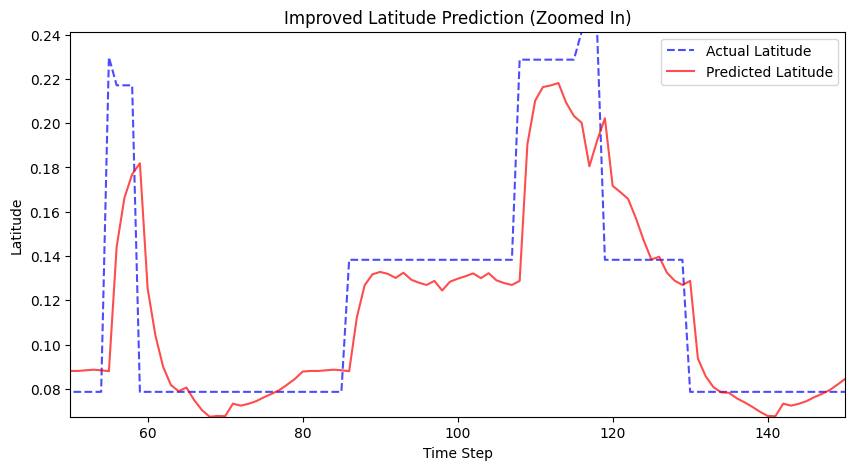

In [ ]:
# Improved Latitude Prediction Visualization with Zoom
plt.figure(figsize=(10, 5))
plt.plot(actual_latitudes, label="Actual Latitude", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(predicted_latitudes, label="Predicted Latitude", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Latitude")
plt.title("Improved Latitude Prediction (Zoomed In)")
# Zoom in on a specific region of the plot
# Example: Zoom in from time step 50 to 150
plt.xlim(50, 150)  # Adjust these values to zoom in on the desired time steps
plt.ylim(min(min(actual_latitudes[50:150]), min(predicted_latitudes[50:150])),
         max(max(actual_latitudes[50:150]), max(predicted_latitudes[50:150])))  # Adjust y-limits dynamically
plt.show()


# Comparison of LSTM and BiLSTM Models for longtiude prediction.

**LSTM (Long Short-Term Memory) Networks:**

LSTMs are a special kind of recurrent neural network (RNN) designed to learn long-range dependencies in sequential data.  Standard RNNs suffer from the vanishing gradient problem, making it difficult for them to remember information from earlier time steps. LSTMs address this by using a gating mechanism that allows them to selectively remember or forget information.  This makes them well-suited for tasks like time series forecasting, natural language processing, and speech recognition where the order of data points is crucial.  Key components of an LSTM cell are: input gate, forget gate, output gate, and cell state.  These gates control the flow of information within the network.

**BiLSTM (Bidirectional Long Short-Term Memory) Networks:**

BiLSTMs enhance LSTMs by processing the input sequence in both forward and backward directions. This allows the network to capture contextual information from both past and future time steps, providing a more complete understanding of the sequence.  For example, in natural language processing, a BiLSTM can consider the context of a word from both preceding and succeeding words, leading to improved accuracy in tasks like sentiment analysis.  Essentially, two LSTMs are used: one processes the input sequence from left to right and the other from right to left, and their outputs are concatenated.

**Code Explanation and Longitude Prediction:**

The code uses both LSTM and BiLSTM models to predict longitude values from a dataset of wildlife traffic data.  The data is preprocessed: dates are converted to datetime objects, features like year, month, day, hour, etc. are extracted, categorical features (like 'highway') are encoded numerically, and all numerical features are normalized using `MinMaxScaler`.

The data is then transformed into sequences of a fixed length (`SEQUENCE_LENGTH`).  Each sequence is used to predict the longitude value at the next time step.  The LSTM and BiLSTM models are trained on this sequential data.  The code includes crucial components like:

* **Model Definition**:  The models are defined using the `tf.keras` API, specifying layers like LSTM/BiLSTM, Dense, Dropout, and BatchNormalization.  Hyperparameters like number of units and dropout rates are set.
* **Compilation**:  Models are compiled with the Adam optimizer and Mean Squared Error (MSE) as the loss function.
* **Training**:  The models are trained on the training dataset, and the validation dataset is used to monitor performance and prevent overfitting.
* **Prediction**: Predictions are made on the test or validation set.
* **Evaluation**:  Evaluation metrics include Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) values.

**Performance Comparison:**

The code visualizes and compares the performance of LSTM and BiLSTM models using various plots.  Visualizations show actual vs. predicted longitude values and residuals (the difference between actual and predicted values).  Note that the provided code performs two separate model trainings and visualizations. The first uses a standard LSTM model and the second one uses a BiLSTM model. The evaluation metrics (MSE, MAE, R²) after each model training and prediction are printed and can be used to compare the models directly.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers

#  Load processed data
file_path = 'processed_wildlife_traffic.csv'
df = pd.read_csv(file_path)

#  Convert eventDate to datetime format
df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce')

# Drop invalid eventDate rows
df = df.dropna(subset=['eventDate'])

# Create time-based features
df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second

#  Handle 'highway' encoding safely
if 'highway' in df.columns:
    df['highway'] = pd.factorize(df['highway'])[0]
else:
    print("⚠️ Warning: 'highway' column missing, removing it from features.")

#  Define feature set dynamically
features = ['decimalLatitude', 'decimalLongitude', 'year', 'month', 'day', 'hour', 'minute', 'second', 'distance_to_road']
if 'highway' in df.columns:
    features.append('highway')

#  Filter features based on availability
features = [col for col in features if col in df.columns]

#  Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

#  Create sequences for LSTM
SEQUENCE_LENGTH = 10

def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length, 1]  # Predict decimalLongitude
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

#  Reshape data for LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

#  Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#  Build LSTM Model for Longitude Prediction
model_longitude = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(32),
    layers.Dense(1)  # Predict longitude
])

model_longitude.compile(optimizer='adam', loss='mse')

#  Train Model
history = model_longitude.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

#  Evaluate Model
loss = model_longitude.evaluate(X_test, y_test)
print(f"✅ Test Loss: {loss}")

#  Save Model
model_longitude.save('wildlife_longitude_lstm_model.keras')

#  Predict on new data
new_data = pd.read_csv('national_wildlife_traffic.csv')

# Ensure new data has required features
missing_new_features = [col for col in features if col not in new_data.columns]
if missing_new_features:
    print(f"⚠️ Warning: Missing features in new data: {missing_new_features}, filling with 0.")
    for col in missing_new_features:
        new_data[col] = 0  # Fill missing columns with default value

#  Reorder columns to match the scaler's training
new_data = new_data[features]

#  Scale new data safely
scaled_new_data = scaler.transform(new_data)

#  Create sequences for new data
new_sequences, _ = create_sequences(scaled_new_data, SEQUENCE_LENGTH)

#  Make predictions
predicted_longitudes = model_longitude.predict(new_sequences)

#  Save predictions
results = pd.DataFrame({
    'actual_longitude': new_data['decimalLongitude'][SEQUENCE_LENGTH:].values,
    'predicted_longitude': predicted_longitudes.flatten()
})

results.to_csv('longitude_predictions.csv', index=False)
print("✅ Longitude predictions saved to 'longitude_predictions.csv'")

#  Compute Metrics
actual_longitudes = results['actual_longitude'].values
predicted_longitudes = results['predicted_longitude'].values

mse = mean_squared_error(actual_longitudes, predicted_longitudes)
mae = mean_absolute_error(actual_longitudes, predicted_longitudes)
r2 = r2_score(actual_longitudes, predicted_longitudes)

print(f"✅ MSE: {mse}\n✅ MAE: {mae}\n✅ R²: {r2}")


⚠️ Warning: 'highway' column missing, removing it from features.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1681/1681 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 2/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 4.0429e-04 - val_loss: 0.0069
Epoch 3/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 3.2303e-04 - val_loss: 0.0049
Epoch 4/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 2.7645e-04 - val_loss: 0.0054
Epoch 5/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 2.5903e-04 - val_loss: 0.0053
Epoch 6/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 2.5877e-04 - val_loss: 0.0032
Epoch 7/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 2.5476e-04 - val_loss: 0.0044
Epoch 8/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 2.6456e-04 - val_loss: 0.0026
Epoch 9/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 2.2953e-04 - val_loss: 0.0033
Epoch 10/10
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 2.4514e-04 - val_loss: 0.0050
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030
✅ Test Loss: 0.004

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0622 - val_loss: 0.0436
Epoch 2/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0464 - val_loss: 0.0420
Epoch 3/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0437 - val_loss: 0.0412
Epoch 4/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0413 - val_loss: 0.0315
Epoch 5/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0340 - val_loss: 0.0300
Epoch 6/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0328 - val_loss: 0.0285
Epoch 7/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0314 - val_loss: 0.0275
Epoch 8/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0290 - val_loss: 0.0263
Epoch 9/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0294 - val_loss: 0.0243
Epoch 10/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0279 - val_loss: 0.0242
Epoch 11/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0265 - val_loss: 0.0240
Epoch 12/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/s

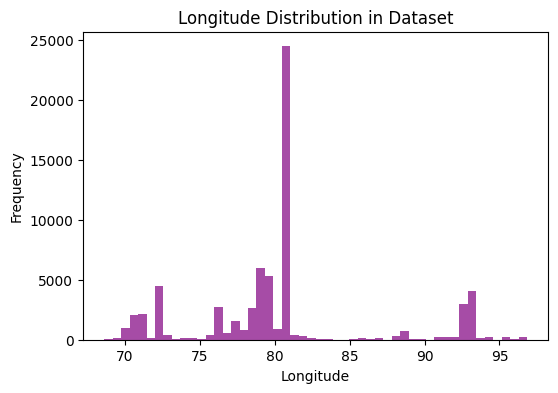

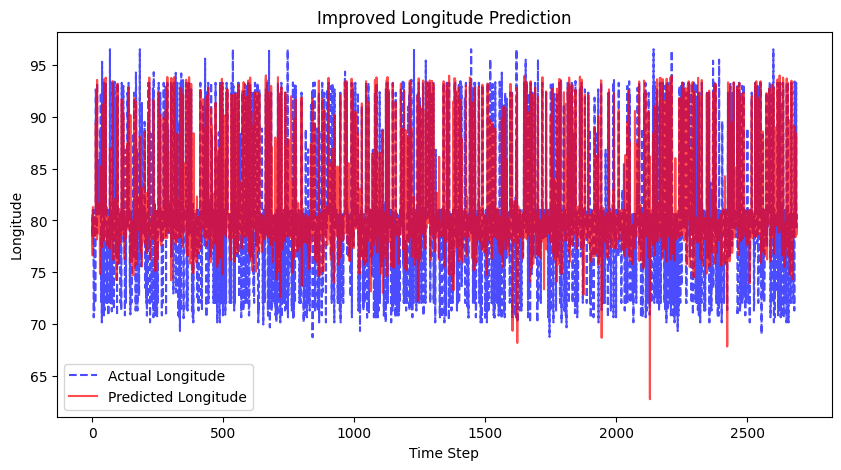

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ✅ Select Features
features = ['decimalLatitude', 'hour', 'distance_to_road',
            'highway_primary', 'highway_secondary', 'highway_tertiary', 'highway_motorway']
X = df[features]
y = df['decimalLongitude']

# ✅ Normalize Features & Target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# ✅ Split Data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# ✅ Define Timesteps
timesteps = 5

# ✅ Make Data Length a Multiple of `timesteps`
train_len = (X_train.shape[0] // timesteps) * timesteps
val_len = (X_val.shape[0] // timesteps) * timesteps

X_train, y_train = X_train[:train_len], y_train[:train_len]
X_val, y_val = X_val[:val_len], y_val[:val_len]

# ✅ Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0] // timesteps, timesteps, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0] // timesteps, timesteps, X_val.shape[1]))

y_train = y_train.reshape((-1, timesteps))[:, -1]  # Take the last timestep as the target
y_val = y_val.reshape((-1, timesteps))[:, -1]

# ✅ Get Number of Features
num_features = X_train.shape[2]

# ✅ Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, num_features)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='mse')

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# ✅ Make Predictions
predicted_longitudes = model.predict(X_val)

# ✅ Inverse Transform Predictions
predicted_longitudes = scaler_y.inverse_transform(predicted_longitudes.reshape(-1, 1))
actual_longitudes = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# ✅ Longitude Distribution Histogram
plt.figure(figsize=(6, 4))
plt.hist(df['decimalLongitude'], bins=50, color='purple', alpha=0.7)
plt.title("Longitude Distribution in Dataset")
plt.xlabel("Longitude")
plt.ylabel("Frequency")
plt.show()

# ✅ Improved Longitude Prediction Visualization
plt.figure(figsize=(10, 5))
plt.plot(actual_longitudes, label="Actual Longitude", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(predicted_longitudes, label="Predicted Longitude", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Longitude")
plt.title("Improved Longitude Prediction")
plt.show()


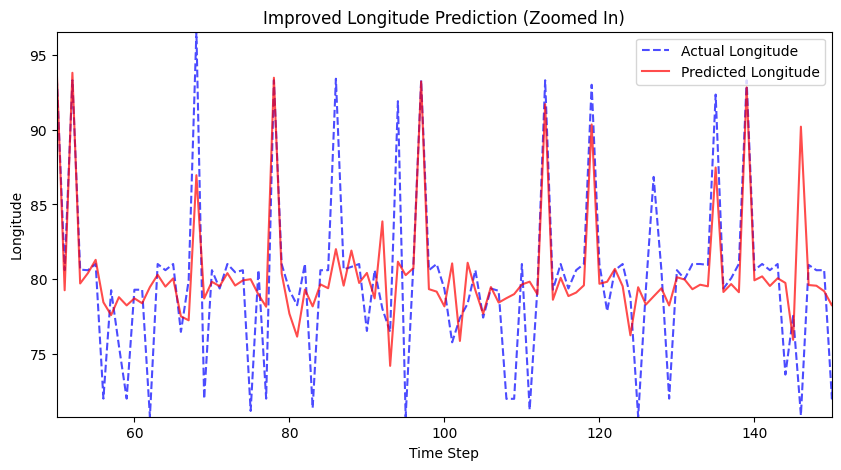

In [ ]:


import matplotlib.pyplot as plt


# Improved Longitude Prediction Visualization with Zoom
plt.figure(figsize=(10, 5))
plt.plot(actual_longitudes, label="Actual Longitude", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(predicted_longitudes, label="Predicted Longitude", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Longitude")
plt.title("Improved Longitude Prediction (Zoomed In)")

# Zoom in on a specific region of the plot
# Example: Zoom in from time step 50 to 150
plt.xlim(50, 150)  # Adjust these values to zoom in on the desired time steps
plt.ylim(min(min(actual_longitudes[50:150]), min(predicted_longitudes[50:150])),
         max(max(actual_longitudes[50:150]), max(predicted_longitudes[50:150])))  # Adjust y-limits dynamically

plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - loss: 0.0756 - val_loss: 0.0617 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - loss: 0.0511 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - loss: 0.0480 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 0.0465 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - loss: 0.0423 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - loss: 0.0375 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - loss: 0.0344 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - loss: 0.0347 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - loss: 0.0312 - val_loss: 0.0270 - learning_rate: 0

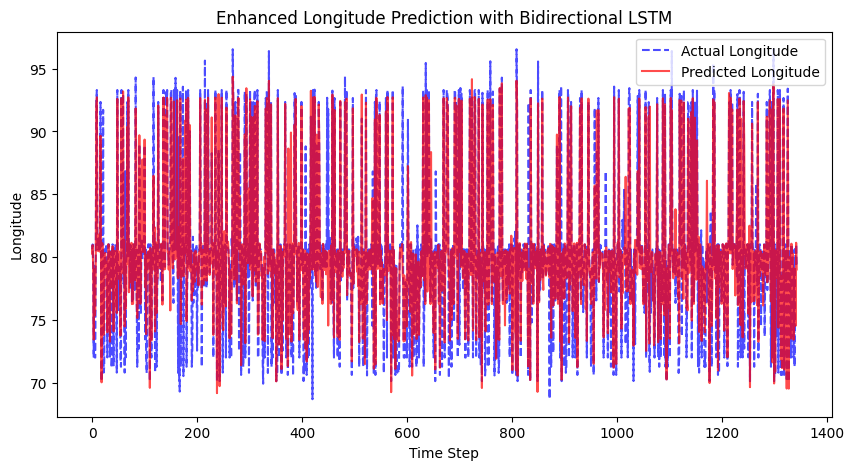

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Select Features
features = ['decimalLatitude', 'hour', 'distance_to_road',
            'highway_primary', 'highway_secondary', 'highway_tertiary', 'highway_motorway']
X = df[features]
y = df['decimalLongitude']

# ✅ Normalize Features & Target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# ✅ Split Data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# ✅ Define Timesteps (Increased)
timesteps = 10  # Increased from 5 to 10

# ✅ Make Data Length a Multiple of `timesteps`
train_len = (X_train.shape[0] // timesteps) * timesteps
val_len = (X_val.shape[0] // timesteps) * timesteps

X_train, y_train = X_train[:train_len], y_train[:train_len]
X_val, y_val = X_val[:val_len], y_val[:val_len]

# ✅ Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0] // timesteps, timesteps, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0] // timesteps, timesteps, X_val.shape[1]))

y_train = y_train.reshape((-1, timesteps))[:, -1]  # Take the last timestep as the target
y_val = y_val.reshape((-1, timesteps))[:, -1]

# ✅ Get Number of Features
num_features = X_train.shape[2]

# ✅ Define Improved LSTM Model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, input_shape=(timesteps, num_features))),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1)
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='mse')

# ✅ Callbacks (Early Stopping & Reduce LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# ✅ Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# ✅ Make Predictions
predicted_longitudes = model.predict(X_val)

# ✅ Inverse Transform Predictions
predicted_longitudes = scaler_y.inverse_transform(predicted_longitudes.reshape(-1, 1))
actual_longitudes = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# ✅ Improved Longitude Prediction Visualization
plt.figure(figsize=(10, 5))
plt.plot(actual_longitudes, label="Actual Longitude", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(predicted_longitudes, label="Predicted Longitude", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Longitude")
plt.title("Enhanced Longitude Prediction with Bidirectional LSTM")
plt.show()


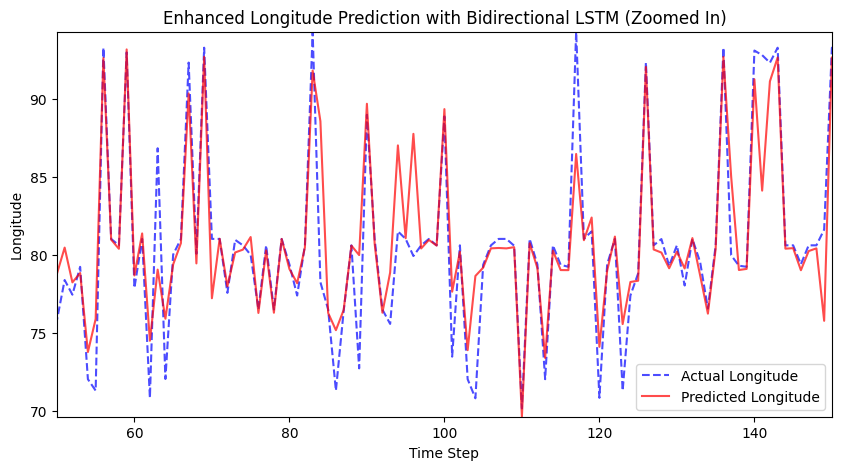

In [ ]:

# Improved Longitude Prediction Visualization with Zoom
plt.figure(figsize=(10, 5))
plt.plot(actual_longitudes, label="Actual Longitude", linestyle='dashed', color='blue', alpha=0.7)
plt.plot(predicted_longitudes, label="Predicted Longitude", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Longitude")
plt.title("Enhanced Longitude Prediction with Bidirectional LSTM (Zoomed In)")

# Zoom in on a specific region of the plot
# Example: Zoom in from time step 50 to 150
zoom_start = 50
zoom_end = 150
plt.xlim(zoom_start, zoom_end)
plt.ylim(min(min(actual_longitudes[zoom_start:zoom_end]), min(predicted_longitudes[zoom_start:zoom_end])),
         max(max(actual_longitudes[zoom_start:zoom_end]), max(predicted_longitudes[zoom_start:zoom_end])))

plt.show()


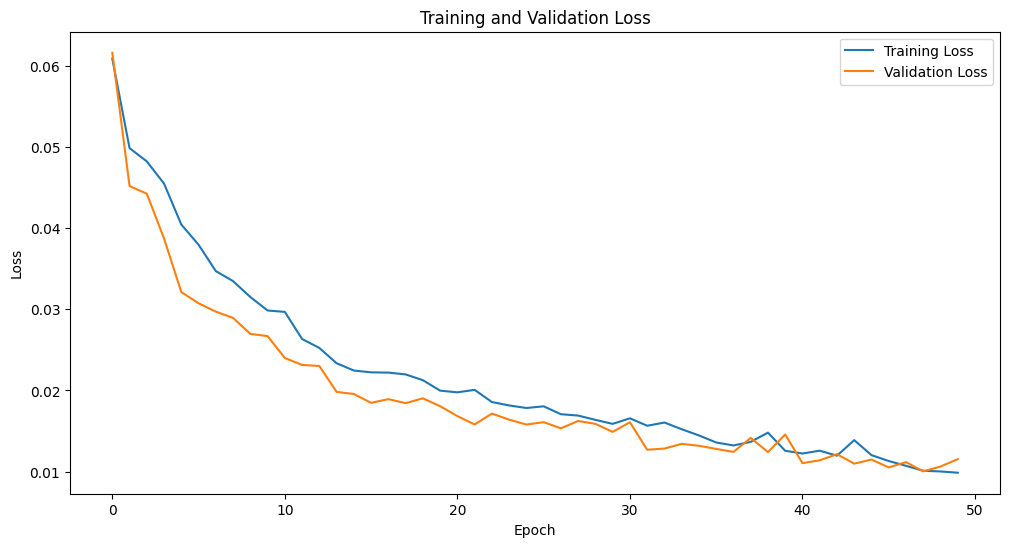

In [ ]:
# Example of improved visualization:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:


# Evaluate the model
mse = mean_squared_error(actual_longitudes, predicted_longitudes)
mae = mean_absolute_error(actual_longitudes, predicted_longitudes)
r2 = r2_score(actual_longitudes, predicted_longitudes)

print(f"✅ MSE: {mse}")
print(f"✅ MAE: {mae}")
print(f"✅ R²: {r2}")


✅ MSE: 7.9688120225285495
✅ MAE: 1.436278753357297
✅ R²: 0.7813871826361707


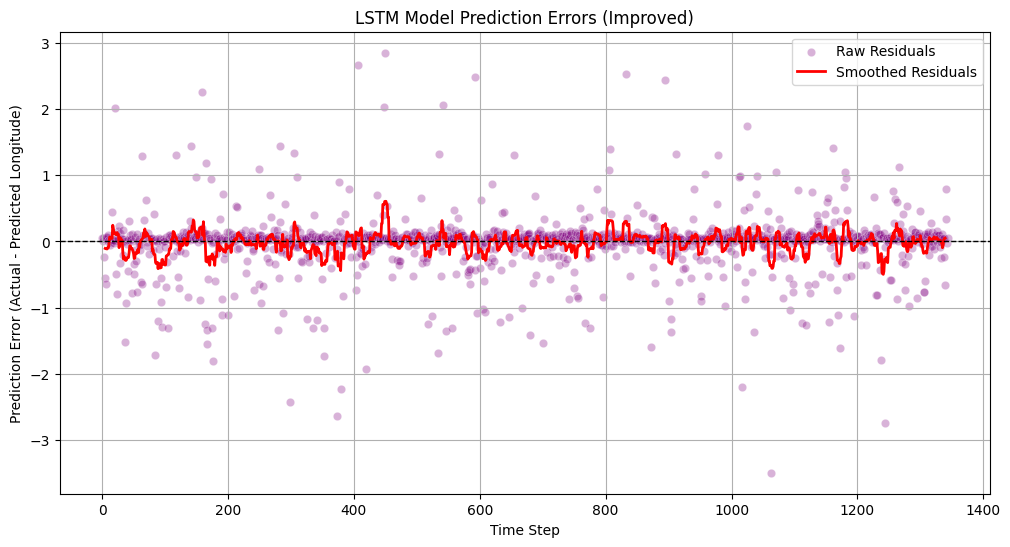

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

#  Normalize actual and predicted longitudes
scaler = StandardScaler()
actual_longitudes = scaler.fit_transform(actual_longitudes.reshape(-1, 1)).flatten()
predicted_longitudes = scaler.transform(predicted_longitudes.reshape(-1, 1)).flatten()

#  Compute residuals
residuals = actual_longitudes[:len(predicted_longitudes)] - predicted_longitudes
time_steps = np.arange(len(residuals))  # Ensure time steps match residuals

#  Apply rolling mean smoothing
window_size = 10  # Adjust based on dataset density
smoothed_residuals = pd.Series(residuals).rolling(window_size, center=True).mean()

#  Plot improved residuals
plt.figure(figsize=(12, 6))
sns.scatterplot(x=time_steps, y=residuals, color='purple', alpha=0.3, label="Raw Residuals")
sns.lineplot(x=time_steps, y=smoothed_residuals, color='red', linewidth=2, label="Smoothed Residuals")
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)  # Zero error reference line
plt.xlabel("Time Step")
plt.ylabel("Prediction Error (Actual - Predicted Longitude)")
plt.title("LSTM Model Prediction Errors (Improved)")
plt.legend()
plt.grid(True)
plt.show()



Original cnn_grid shape: (2359, 2359), Total elements: 5564881
🔹 Reshaped cnn_grid to: (1, 256, 256, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.6931 - val_accuracy: 1.0000 - val_loss: 0.6892
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 1.0000 - loss: 0.6892 - val_accuracy: 1.0000 - val_loss: 0.6838
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 1.0000 - loss: 0.6838 - val_accuracy: 1.0000 - val_loss: 0.6774
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 1.0000 - loss: 0.6774 - val_accuracy: 1.0000 - val_loss: 0.6694
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 1.0000 - loss: 0.6694 - val_accuracy: 1.0000 - val_loss: 0.6594
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 1.0000 - loss: 0.6594 - val_accuracy: 1.0000 - val_loss: 0.6468
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 1.0000 - loss: 0.6468 - val_accuracy: 1.0000 - val_loss: 0.6314
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 1.0000 - loss: 0.6314 - val_accuracy: 1.0000 - val_loss: 0.

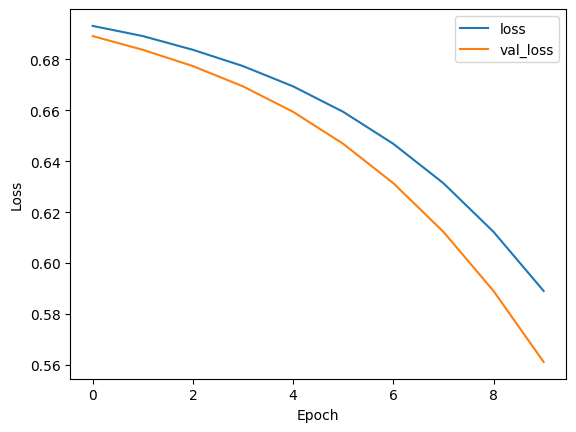

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

cnn_grid = np.load('cnn_grid_data.npy')

print(f"Original cnn_grid shape: {cnn_grid.shape}, Total elements: {cnn_grid.size}")

TARGET_SIZE = 256
cnn_grid_resized = cv2.resize(cnn_grid, (TARGET_SIZE, TARGET_SIZE))

cnn_grid_resized = cnn_grid_resized.reshape((1, TARGET_SIZE, TARGET_SIZE, 1))
print(f"🔹 Reshaped cnn_grid to: {cnn_grid_resized.shape}")

X_train, X_test = cnn_grid_resized[:1], cnn_grid_resized[:1]
y_train = np.array([1])
y_test = np.array([1])

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test))

model.save('wildlife_risk_cnn_model.keras')
print("✅ CNN Model Saved!")

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
mse = mean_squared_error(actual_longitudes, predicted_longitudes)
mae = mean_absolute_error(actual_longitudes, predicted_longitudes)
r2 = r2_score(actual_longitudes, predicted_longitudes)

print(f"✅ MSE: {mse}")
print(f"✅ MAE: {mae}")
print(f"✅ R²: {r2}")


✅ MSE: 0.23805243024146985
✅ MAE: 0.2699731166601967
✅ R²: 0.7619475697585302
